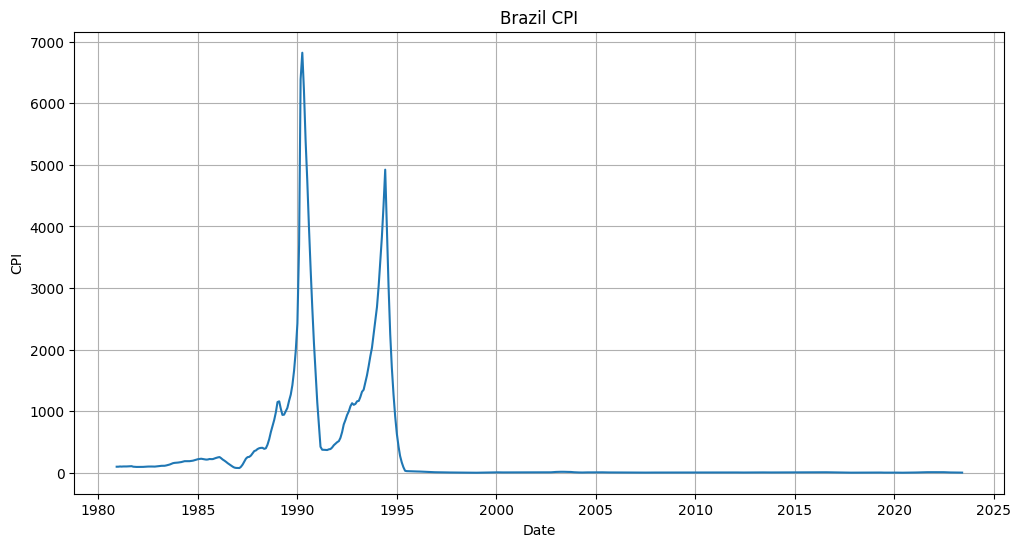

[*********************100%***********************]  1 of 1 completed


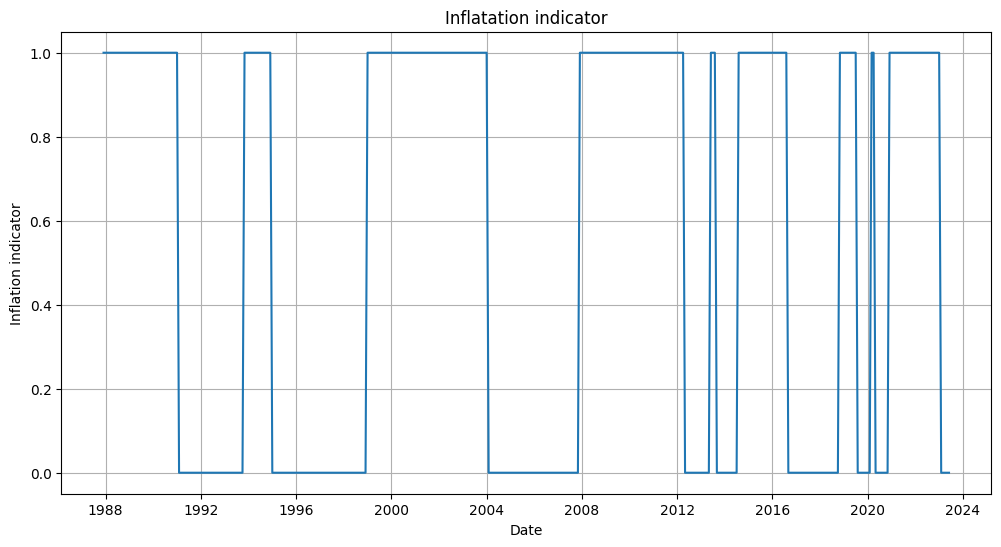

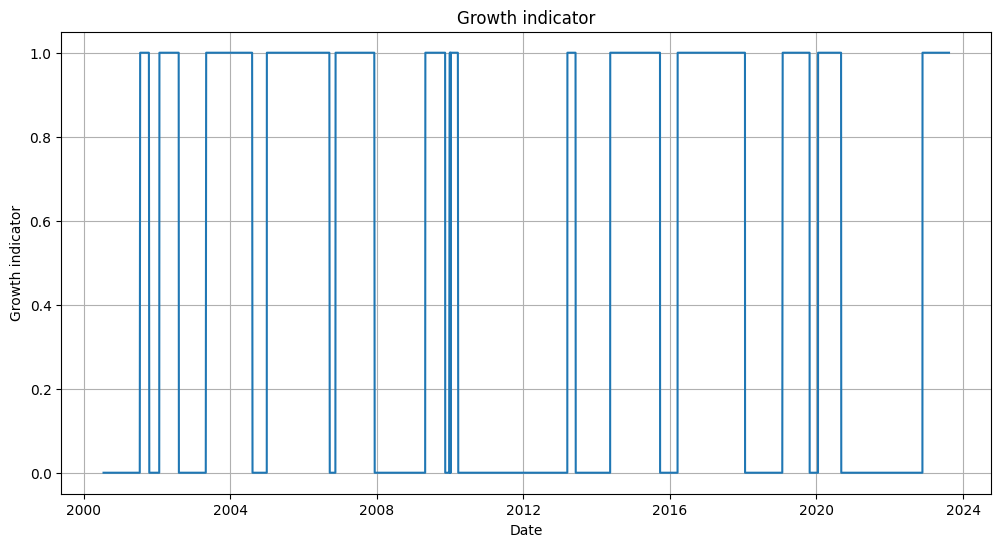

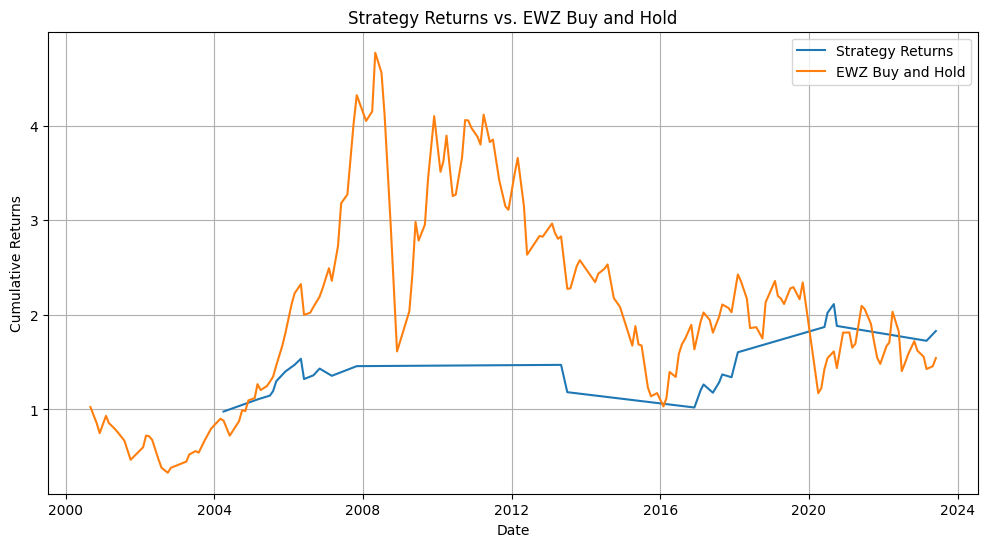

CAGR: 3.32%
Max Drawdown: -33.53%
Sharpe ratio: 4.292418267559543


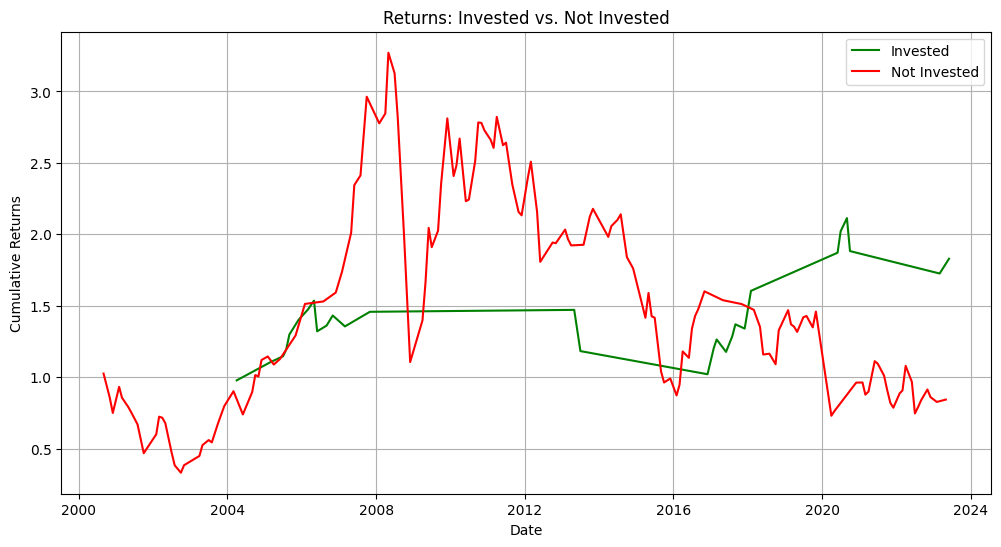

In [11]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression

def convert_date_to_ordinal(date):
    return date.toordinal()

def calculate_slope(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

cpi_data = fred.get_series('CPALTT01BRM659N')
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cpi_data)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Brazil CPI')
plt.grid()
plt.show()


ewz = yf.download('EWZ', start='2000-01-01', end='2023-06-19')
ewz_close = ewz['Close']

# Compute daily returns for EWJ
merged_data['ewz_returns'] = merged_data['Close'].pct_change()

oil_price = fred.get_series('DCOILWTICO')
oil_price = oil_price[oil_price > 0]
oil_log = np.log(oil_price.dropna())
ewz_oil_log_ratio = np.log(ewz_close).div(oil_log, axis=0)

inflation_indicator = pd.Series(index=cpi_df.index)
growth_indicator = pd.Series(index=ewz_oil_log_ratio.index)

for i in range(12 * 7, len(cpi_df)):
    X = cpi_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = cpi_df['log_CPI'].iloc[:i].values

    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])

    model_7 = LinearRegression()
    model_7.fit(X[-12 * 7:], y[-12 * 7:])

    y_pred_1 = model_1.predict([X[-1]])
    y_pred_7 = model_7.predict([X[-1]])

    inflation_indicator.iloc[i] = 1 if y_pred_7[-1] < y_pred_1[-1] else 0

for date in ewz_oil_log_ratio.index:
    one_year_ago = date - DateOffset(years=1)
    last_year_data = ewz_oil_log_ratio[(ewz_oil_log_ratio.index >= one_year_ago) & (ewz_oil_log_ratio.index < date)].dropna()
    seven_years_ago = date - DateOffset(years=7)
    last_seven_years_data = ewz_oil_log_ratio[(ewz_oil_log_ratio.index >= seven_years_ago) & (ewz_oil_log_ratio.index < date)].dropna()
    
    if not last_year_data.empty and not last_seven_years_data.empty:
        X1 = np.array(last_year_data.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_data.values
        X7 = np.array(last_seven_years_data.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y7 = last_seven_years_data.values
        growth_indicator[date] = int(calculate_slope(X7, y7) < calculate_slope(X1, y1))

indicators = pd.concat([inflation_indicator, growth_indicator], axis=1)
indicators.columns = ['inflation_indicator', 'growth_indicator']
indicators = indicators.dropna()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(inflation_indicator)
plt.xlabel('Date')
plt.ylabel('Inflation indicator')
plt.title('Inflatation indicator')
plt.grid()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(growth_indicator)
plt.xlabel('Date')
plt.ylabel('Growth indicator')
plt.title('Growth indicator')
plt.grid()
plt.show()


nfci_data = pd.read_csv('nfci.csv')
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
nfci_data.set_index('date', inplace=True)
nfci_data.drop(columns=['DATE'], inplace=True)
nfci_data_daily = nfci_data.resample("D").ffill()
nfci_data_daily['nfci_sma_14'] = nfci_data_daily['NFCI'].rolling(window=14).mean()
nfci_data_daily['signal'] = np.where(nfci_data_daily['NFCI'] < nfci_data_daily['nfci_sma_14'], 1, 0)

merged_data = pd.concat([ewz_close, indicators], axis=1).dropna()
merged_data['ewz_returns'] = merged_data['Close'].pct_change()
merged_data['cum_returns_00'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 0) & (merged_data['growth_indicator'] == 0), 'ewz_returns']).cumprod()
merged_data['cum_returns_01'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 0) & (merged_data['growth_indicator'] == 1), 'ewz_returns']).cumprod()
merged_data['cum_returns_10'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 1) & (merged_data['growth_indicator'] == 0), 'ewz_returns']).cumprod()
merged_data['cum_returns_11'] = (1 + merged_data.loc[(merged_data['inflation_indicator'] == 1) & (merged_data['growth_indicator'] == 1), 'ewz_returns']).cumprod()
merged_data[['cum_returns_00', 'cum_returns_01', 'cum_returns_10', 'cum_returns_11']] = merged_data[['cum_returns_00', 'cum_returns_01', 'cum_returns_10', 'cum_returns_11']].fillna(method='ffill')
merged_data['cum_returns_buy_and_hold'] = (1 + merged_data['ewz_returns']).cumprod()

merged_data = merged_data.merge(nfci_data_daily[['NFCI', 'signal']], how='left', left_index=True, right_index=True)
invested = merged_data[(merged_data['inflation_indicator'].shift(1) == 0) & (merged_data['growth_indicator'].shift(1) == 1) & (merged_data['signal'].shift(1) == 1)].copy()
invested['daily_portfolio_value'] = (1 + invested['ewz_returns']).cumprod()


# Calculate EWJ Buy and Hold cumulative returns
ewz_cum_returns_buy_and_hold = (1 + merged_data['ewz_returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(invested.index, invested['daily_portfolio_value'], label='Strategy Returns')
plt.plot(merged_data.index, ewz_cum_returns_buy_and_hold, label='EWZ Buy and Hold')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Returns vs. EWZ Buy and Hold')
plt.grid()
plt.show()

# Adjusted CAGR calculation
invested_days = (invested.index[-1] - invested.index[0]).days / 365.25
CAGR = (invested['daily_portfolio_value'][-1] / invested['daily_portfolio_value'][0]) ** (1 / invested_days) - 1

invested['cumulative_max_value'] = invested['daily_portfolio_value'].cummax()
invested['drawdown'] = invested['daily_portfolio_value'] / invested['cumulative_max_value'] - 1
max_drawdown = invested['drawdown'].min()
daily_rf_rate = 0
excess_daily_returns = invested['ewz_returns'] - daily_rf_rate
sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns) * np.sqrt(252)

print(f"CAGR: {CAGR * 100:.2f}%")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Sharpe ratio: {sharpe_ratio}")


# Calculate cumulative returns for days when strategy is invested
invested = merged_data[(merged_data['inflation_indicator'].shift(1) == 0) & (merged_data['growth_indicator'].shift(1) == 1) & (merged_data['signal'].shift(1) == 1)].copy()
invested['cumulative_returns_invested'] = (1 + invested['ewz_returns']).cumprod()

# Calculate cumulative returns for days when strategy is not invested
not_invested = merged_data[~((merged_data['inflation_indicator'].shift(1) == 0) & (merged_data['growth_indicator'].shift(1) == 1) & (merged_data['signal'].shift(1) == 1))].copy()
not_invested['cumulative_returns_not_invested'] = (1 + not_invested['ewz_returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(invested.index, invested['cumulative_returns_invested'], label='Invested', color='green')
plt.plot(not_invested.index, not_invested['cumulative_returns_not_invested'], label='Not Invested', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Returns: Invested vs. Not Invested')
plt.grid()
plt.show()